In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
from sklearn.model_selection import train_test_split
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png')
from IPython.core.pylabtools import figsize
figsize(10, 6) # Width and hight
#plt.style.use('seaborn-white')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#import graphviz


In [2]:
dataframe = pd.read_csv("train.csv")
dataframe_tst=pd.read_csv("test.csv")
#dataframe_tst=pd.read_csv("test.csv")

In [3]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


X=dataframe[[ 'Number words female', 'Total words', 'Number of words lead','Difference in words lead and co-lead', 'Number of male actors', 'Year','Number of female actors', 'Gross','Age Lead', 'Age Co-Lead']]
Y=dataframe[['Lead']]

for df in dataframe,dataframe_tst:
    
    df['Words_per_actor_F'] = df['Number words female']/df['Number of female actors']
    df['Words_per_actor_M'] = df['Number words male']/df['Number of male actors']
    df['Word_ratio_female'] = df['Number words female'] / df['Total words']
    df['Word_ratio_male'] = df['Number words male'] / df['Total words']
    df['Age_diff_lead&Co-Lead']= abs(df['Age Lead'] - df['Age Co-Lead'])
    
train, test = train_test_split(dataframe, test_size=0.3,shuffle=False)
X1=dataframe.loc[:,~dataframe.columns.isin(['Lead'])]
feature_names = list(X1.columns.values)
feature_names


['Number words female',
 'Total words',
 'Number of words lead',
 'Difference in words lead and co-lead',
 'Number of male actors',
 'Year',
 'Number of female actors',
 'Number words male',
 'Gross',
 'Mean Age Male',
 'Mean Age Female',
 'Age Lead',
 'Age Co-Lead',
 'Words_per_actor_F',
 'Words_per_actor_M',
 'Word_ratio_female',
 'Word_ratio_male',
 'Age_diff_lead&Co-Lead']

In [4]:
#hyperparameter tuning


# criterion = ['gini', 'entropy','log_loss']
# max_depth = [2,4,6,8,10,12]


parameters = {"criterion":('gini', 'entropy'),
                }
acc_l=[]
itr=[]

for i in [3,4,5,6,7,8,9,10,11,12,14,13,15,20,25,30,40,50,60,70,80,90,100,125,150,200]:
    itr.append(i)
parameters["max_depth"]=tuple(itr)


fvalue_Best = SelectKBest(chi2, k=12)
X_kbest = fvalue_Best.fit_transform(X1, Y)
#print(X_kbest)

# print('Original number of features:', X1.shape)
# print('Reduced number of features:', X_kbest.shape)

mask = fvalue_Best.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

X_train=train.loc[:,dataframe.columns.isin(new_features)]
Y_train=train[['Lead']]
X_test=test.loc[:,dataframe.columns.isin(new_features)]
Y_test=test[['Lead']]
for i in range(2,25):
    model =GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = i
    ) 
    res=model.fit(X=X_train, y=Y_train)
    acc_l.append((res.best_score_ )*100)
print(max(acc_l))
print(acc_l.index(max(acc_l))) 
model =GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = acc_l.index(max(acc_l))
    ) 
res=model.fit(X_train, Y_train.values.ravel())
prediction = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test, prediction).ravel()
print("Accuracy =",(tp+tn)/(tp+fp+tn+fn))
print("Precision =",(tp)/(tp+fp))
print("Sensitivity =",(tp)/(tp+fn))
print("Specificity =",(tn)/(fp+tn))

# predict_prob = model.predict_proba(X_test)
# prediction = np.empty(len(X_test), dtype=object)
# prediction = np.where(predict_prob[:, 0]>=0.5, 'Female', 'Male')
# print('Accuracy:',(np.mean(prediction == np.concatenate(Y_test.to_numpy())))*100,'%')

# print('Accuracy:',(res.best_score_ )*100,"%")
# res.best_params_
#model = tree.DecisionTreeClassifier(max_depth=3)
#model.fit(X=X_train, y=Y_train)

85.54804804804806
18
Accuracy = 0.7692307692307693
Precision = 0.8214285714285714
Sensitivity = 0.8518518518518519
Specificity = 0.5833333333333334


In [5]:
# Accuracy = 0.7564102564102564
# Precision = 0.7941176470588235
# Sensitivity = 0.875
# Specificity = 0.4895833333333333

/Users/vijayaadhithan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


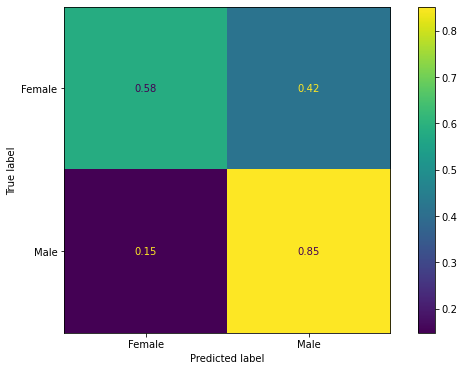

In [6]:
plot_confusion_matrix(model,X_test,Y_test,normalize='true')

In [7]:
predict_prob = model.predict_proba(X_test)
prediction = np.empty(len(X_test), dtype=object)
prediction = np.where(predict_prob[:, 0]>=0.5, 'Female', 'Male')

print(classification_report(Y_test,prediction)) #np.concatenate(Y_test.to_numpy())

              precision    recall  f1-score   support

      Female       0.64      0.58      0.61        96
        Male       0.82      0.85      0.84       216

    accuracy                           0.77       312
   macro avg       0.73      0.72      0.72       312
weighted avg       0.76      0.77      0.77       312



In [8]:
#naive classifier
print('Accuracy:')
print(f"{np.mean(np.concatenate(Y_test.to_numpy()) == 'Male'):.3f}")

Accuracy:
0.692
